# Setup

In [168]:
import pandas as pd
import numpy as np


# Preprocessing
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re    
from bs4 import BeautifulSoup
import string

# Modelling
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import naive_bayes

# Visualize
import seaborn as sns
import plotly.express as px
sns.set(rc={'figure.figsize':(15,9)})

# Data

In [3]:
south = pd.read_excel('../data/Tweets_etiqueta.xlsx', sheet_name='SouthwestAir')
south['airline'] = 'SouthwestAir'
south.head()

,Responsable,Texto,Sentimiento,airline
0,V,@SouthwestAir What about bike fees,0.0,SouthwestAir
1,V,@SouthwestAir I ❤️ SWA,1.0,SouthwestAir
2,V,@SouthwestAir Mask mandate tho,0.0,SouthwestAir
3,V,@SouthwestAir has ripped me off by delaying my...,-1.0,SouthwestAir
4,V,@SouthwestAir I’ll take my chances with @Delta...,0.0,SouthwestAir


In [4]:
jetblue = pd.read_excel('../data/Tweets_etiqueta.xlsx', sheet_name='JetBlue')
jetblue['airline'] = 'JetBlue'
jetblue.head()

,Responsable,Texto,Sentimiento,airline
0,V,@JustinMeyerKC @JetBlue @KCIAirport Cheers fro...,0.0,JetBlue
1,V,@caseycgolden @SpiritAirlines @JetBlue That so...,-1.0,JetBlue
2,V,"Hey @JetBlue, it’s been four days since you lo...",-1.0,JetBlue
3,V,@JustinMeyerKC @JetBlue Wil they be releasing ...,0.0,JetBlue
4,V,You can have your cake and eat it too when you...,0.0,JetBlue


In [5]:
df = pd.concat(    
    [
        south,
        jetblue
    ]
)

df = df.loc[df.Sentimiento.isin([1,-1]), ['Texto', 'Sentimiento','airline']]
df.columns = [x.lower() for x in df.columns]

df.head()

,texto,sentimiento,airline
1,@SouthwestAir I ❤️ SWA,1.0,SouthwestAir
3,@SouthwestAir has ripped me off by delaying my...,-1.0,SouthwestAir
5,@SouthwestAir I checked two bags and still had...,1.0,SouthwestAir
8,@SouthwestAir Just looked at flights to Seattl...,1.0,SouthwestAir
9,@Mike__Green @SouthwestAir And any last shred ...,-1.0,SouthwestAir


In [20]:
df['sentiment'] = df.sentimiento.apply(
    lambda x: 1 if x == 1 else 0
)

df.sentiment.value_counts()

0    2009
1     703
Name: sentimiento, dtype: int64

# EDA

In [165]:
punc = string.punctuation

In [166]:
df['word_count'] = df['texto'].apply(lambda x : len(x.split()))
df['char_count'] = df['texto'].apply(lambda x : len(x.replace(" ","")))
df['word_density'] = df['word_count'] / (df['char_count'] + 1)
df['punc_count'] = df['texto'].apply(lambda x : len([a for a in x if a in punc]))

df[['word_count', 'char_count', 'word_density', 'punc_count']].head()

,word_count,char_count,word_density,punc_count
0,53,233,0.226496,12
1,9,46,0.191489,3
2,12,73,0.162162,7
3,35,142,0.244755,6
4,35,162,0.214724,1


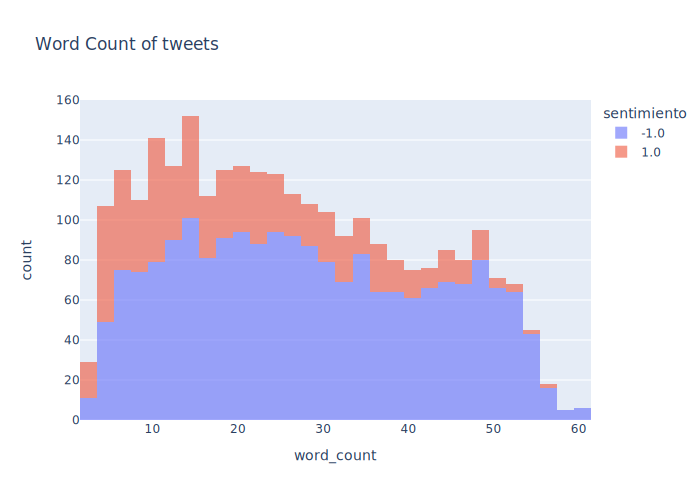

In [169]:
fig = px.histogram(
    df, 
    x="word_count", 
    color="sentimiento",
    title='Word Count of tweets'
    
)
fig.update_traces(opacity=0.6)
fig.show(renderer="svg")

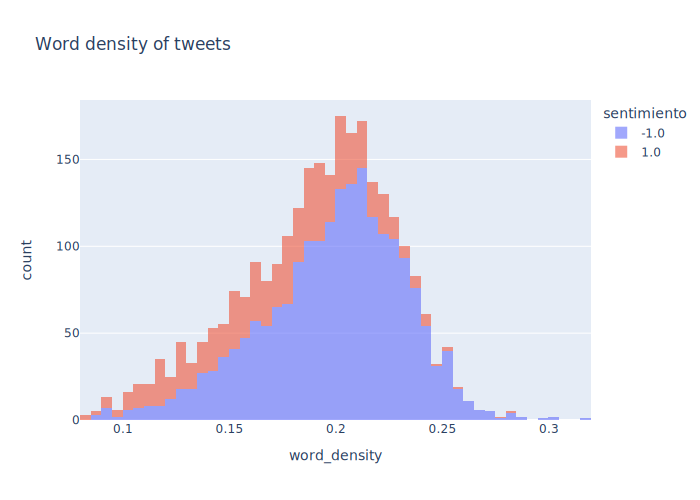

In [170]:
fig = px.histogram(
    df, 
    x="word_density", 
    color="sentimiento",
    title='Word density of tweets'
    
)
fig.update_traces(opacity=0.6)
fig.show(renderer="svg")

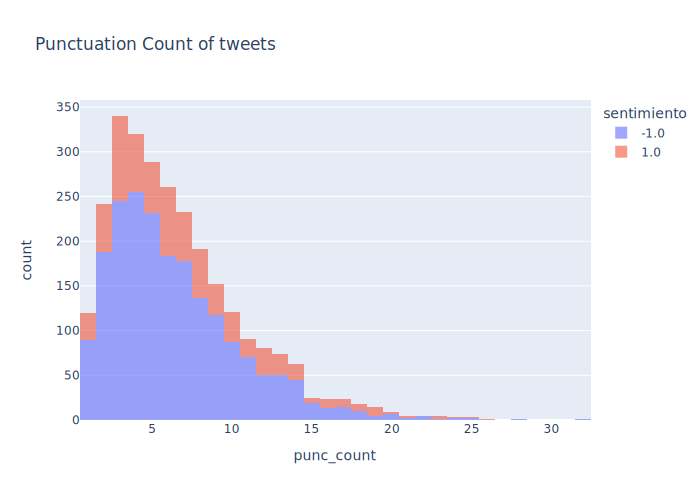

In [171]:
fig = px.histogram(
    df, 
    x="punc_count", 
    color="sentimiento",
    title='Punctuation Count of tweets'
    
)
fig.update_traces(opacity=0.6)
fig.show(renderer="svg")

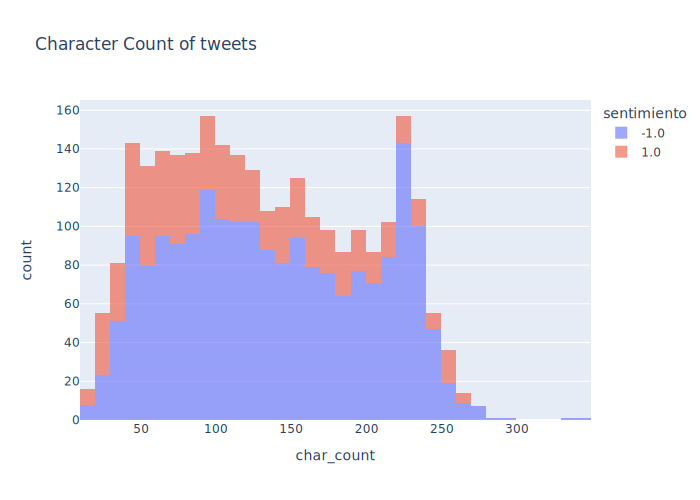

In [172]:
fig = px.histogram(
    df, 
    x="char_count", 
    color="sentimiento",
    title='Character Count of tweets'
    
)
fig.update_traces(opacity=0.6)
fig.show(renderer="svg")

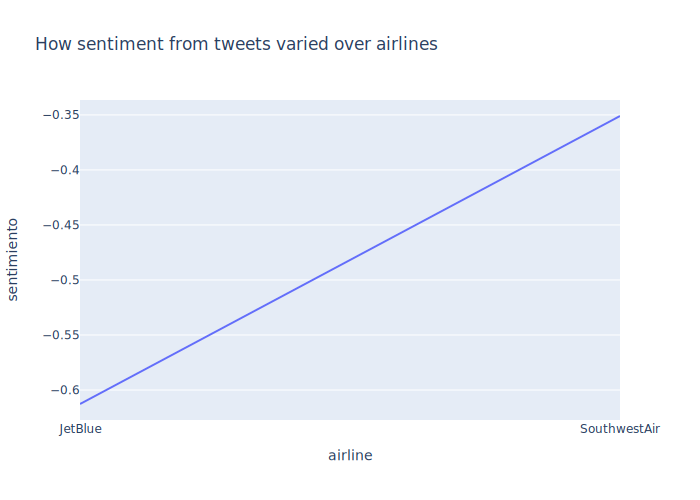

In [173]:
aggdf = df.reset_index().groupby(by=['airline']).agg({'sentimiento':'mean'}).reset_index()

fig = px.line(
    aggdf,
    x='airline', 
    y='sentimiento',
    title='How sentiment from tweets varied over airlines'
)
fig.show(renderer="svg")

# Preprocessing

In [142]:
def clean_tweet(x):
    clean_x = BeautifulSoup(x).get_text()
    clean_x = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", clean_x).split())
    clean_x = ' '.join(re.sub("(\w+:\/\/\S+)", " ", clean_x).split())
    clean_x = ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", clean_x).split())
    clean_x = clean_x.lower()

    return clean_x
    

In [143]:
df['clean_text'] = df.texto.apply(clean_tweet)
# df['texto'].apply(lambda x : ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", x).split()))

In [144]:
df.iloc[0,0], df.iloc[0,-1]

('Photo of the LCD of the GoPro we bought just for this flight. Looks like we got some great video. Presently recharging so we can capture the water salute upon landing to honor @JetBlue bringing service to @KCIAirport. #JetblueMCI https://t.co/zYsXbJXpHL',
 'photo of the lcd of the gopro we bought just for this flight looks like we got some great video presently recharging so we can capture the water salute upon landing to honor bringing service to')

# Modelling

In [145]:
df["kfold"] = -1
df = df.sample(frac=1).reset_index(drop=True)
y = df.sentiment.values
kf = model_selection.StratifiedKFold(n_splits=5)


for f, (t_, v_) in enumerate(kf.split(X=df, y=y)): 
    df.loc[v_, 'kfold'] = f

In [147]:
def model_in_folds(model_selected, model_name, preprocessing='CountVec'):
    
    accuracies = []
    recalls = []
    f1_scores = []
    folds = []
    aucs = []
    for fold_ in range(5):
        train_df = df[df.kfold != fold_].reset_index(drop=True)

        test_df = df[df.kfold == fold_].reset_index(drop=True)
        # Transformation
        if preprocessing == 'CountVec':
            count_vec = CountVectorizer(
                tokenizer=word_tokenize,
                token_pattern=None 
            )
            count_vec.fit(train_df.clean_text)
            xtrain = count_vec.transform(train_df.clean_text) 
            xtest = count_vec.transform(test_df.clean_text)
        elif preprocessing == 'tfidf':
            tfidf_vec = TfidfVectorizer(
                tokenizer=word_tokenize, 
                token_pattern=None, 
                ngram_range=(1, 3)
            )
            # fit count_vec on training data reviews
            tfidf_vec.fit(train_df.clean_text)
            # transform training and validation data reviews
            xtrain = tfidf_vec.transform(train_df.clean_text) 
            xtest = tfidf_vec.transform(test_df.clean_text)
            
        # Training
        model = model_selected
        model.fit(xtrain, train_df.sentiment) 
        
        # Scoring
        proba = model.predict_proba(xtest)[:,1]
        preds = model.predict(xtest)
        
        # Performance measure
        accuracy = metrics.accuracy_score(test_df.sentiment, preds)
        recall = metrics.recall_score(test_df.sentiment, preds)
        f1_score = metrics.f1_score(test_df.sentiment, preds)
        auc = metrics.roc_auc_score(test_df.sentiment, proba)
        
        accuracies.append(accuracy)
        recalls.append(recall)
        f1_scores.append(f1_score)
        folds.append(fold_)
        aucs.append(auc)
            
    df_results = pd.DataFrame(
        {
            'fold':folds,
            'recall':recalls,
            'accuracy':accuracies,
            'f1_score':f1_scores,
            'auc':aucs
        }
    )
    
    df_results['preprocessing'] = preprocessing
    df_results['model'] = model_name
           
    return df_results

## Logistic regression

In [155]:
lst_results = [
    model_in_folds(
        linear_model.LogisticRegression(solver='lbfgs', max_iter=1000),
                'LogisticRegression',
        'CountVec',
    ),
    model_in_folds(
        linear_model.LogisticRegression(solver='lbfgs', max_iter=1000),
        'LogisticRegression',
                'tfidf',
    )
]


In [156]:
results_data = pd.concat(lst_results)
results_data.head()

,fold,recall,accuracy,f1_score,auc,preprocessing,model
0,0,0.539007,0.852670,0.655172,0.891024,CountVec,LogisticRegression
1,1,0.609929,0.867403,0.704918,0.900145,CountVec,LogisticRegression
2,2,0.657143,0.854244,0.699620,0.874449,CountVec,LogisticRegression
3,3,0.650000,0.854244,0.697318,0.889908,CountVec,LogisticRegression
4,4,0.595745,0.846863,0.669323,0.880609,CountVec,LogisticRegression


In [150]:
def plot_results(results_data, variable, model):
    results_data.pivot_table(
        index='fold',
        columns='preprocessing',
        values=variable
    ).plot(kind='bar', title=f'{variable} for {model}')


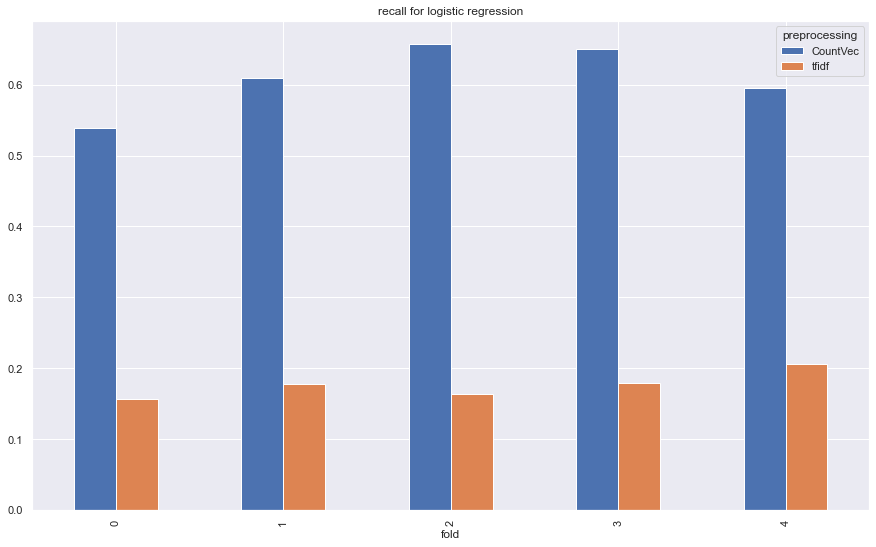

In [151]:
plot_results(results_data, 'recall', 'logistic regression')

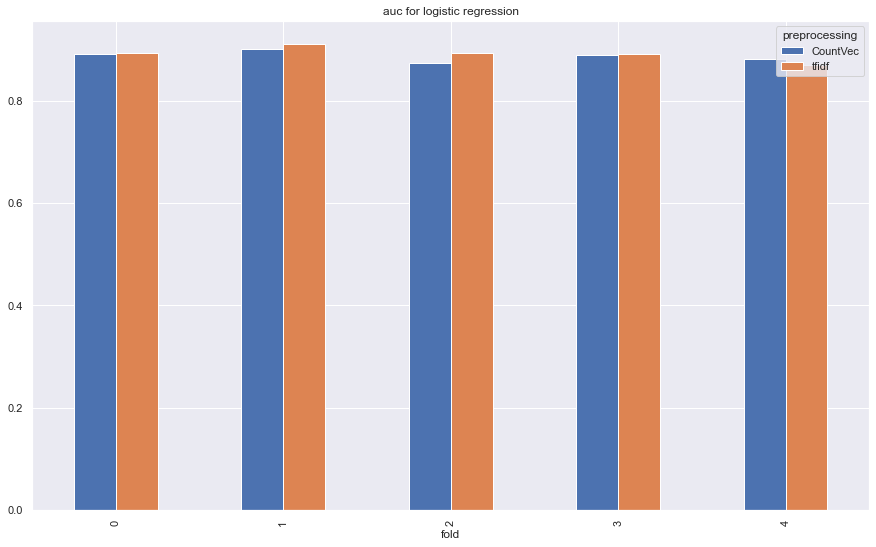

In [152]:
plot_results(results_data, 'auc', 'logistic regression')

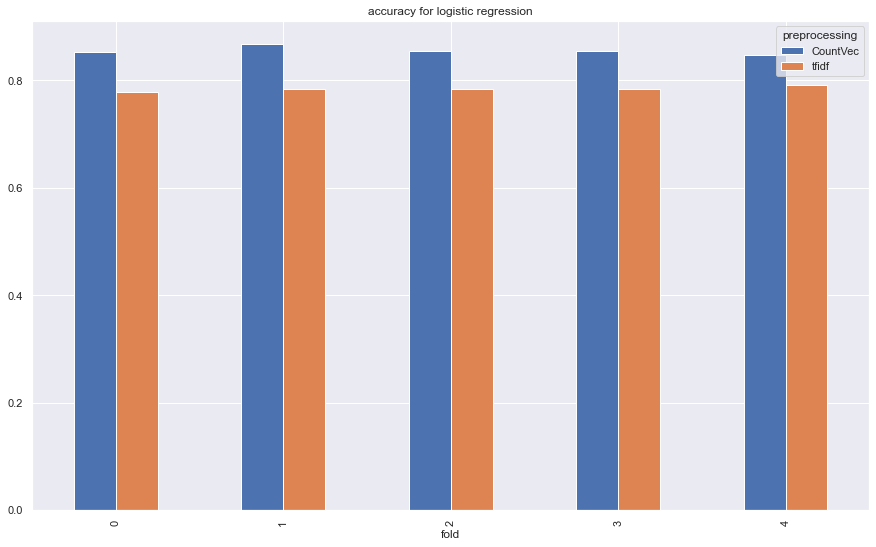

In [153]:
plot_results(results_data, 'accuracy', 'logistic regression')

## Naive Bayes

In [157]:
lst_results = [
    model_in_folds(
        naive_bayes.MultinomialNB(),
                'LogisticRegression',
        'CountVec',
    ),
    model_in_folds(
        naive_bayes.MultinomialNB(),
        'LogisticRegression',
                'tfidf',
    )
]

In [158]:
results_data = pd.concat(lst_results)
results_data.head()

,fold,recall,accuracy,f1_score,auc,preprocessing,model
0,0,0.460993,0.852670,0.619048,0.887460,CountVec,LogisticRegression
1,1,0.439716,0.843462,0.593301,0.907625,CountVec,LogisticRegression
2,2,0.478571,0.850554,0.623256,0.865405,CountVec,LogisticRegression
3,3,0.492857,0.850554,0.630137,0.889677,CountVec,LogisticRegression
4,4,0.418440,0.835793,0.570048,0.861773,CountVec,LogisticRegression


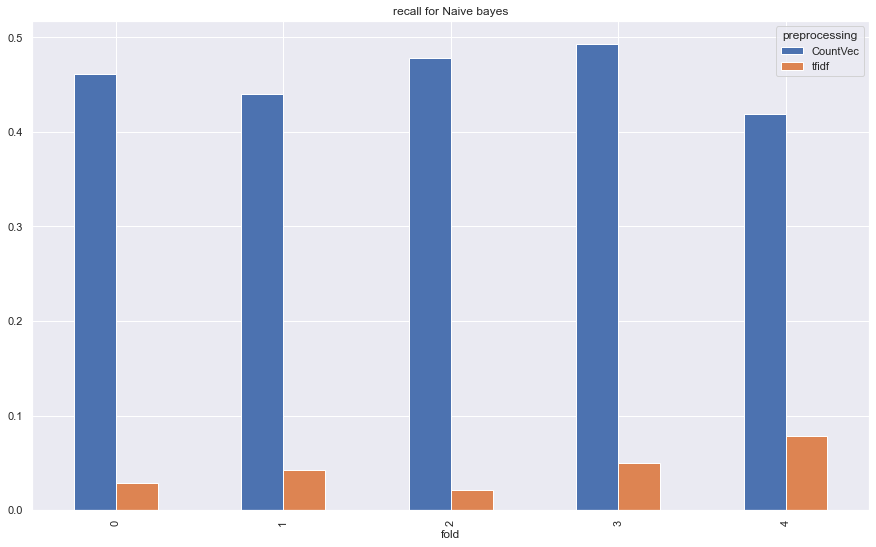

In [174]:
plot_results(results_data, 'recall', 'Naive bayes')

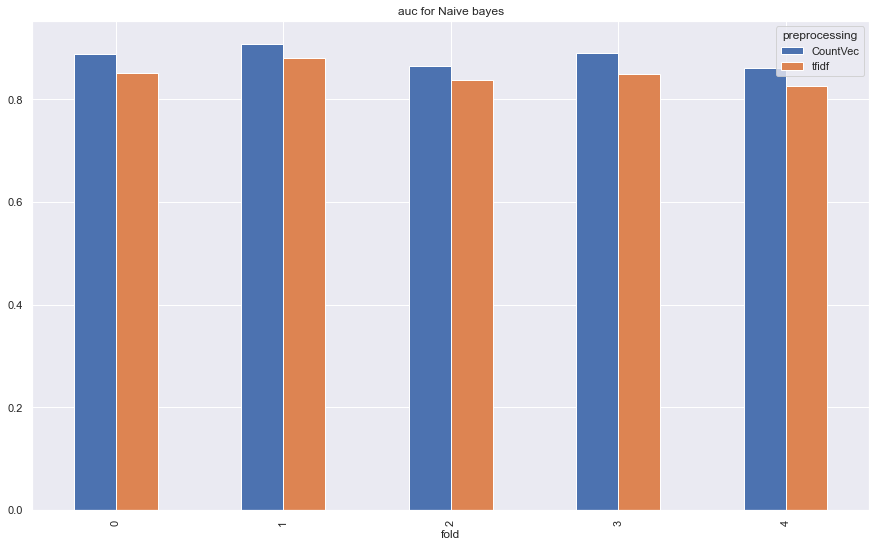

In [175]:
plot_results(results_data, 'auc', 'Naive bayes')

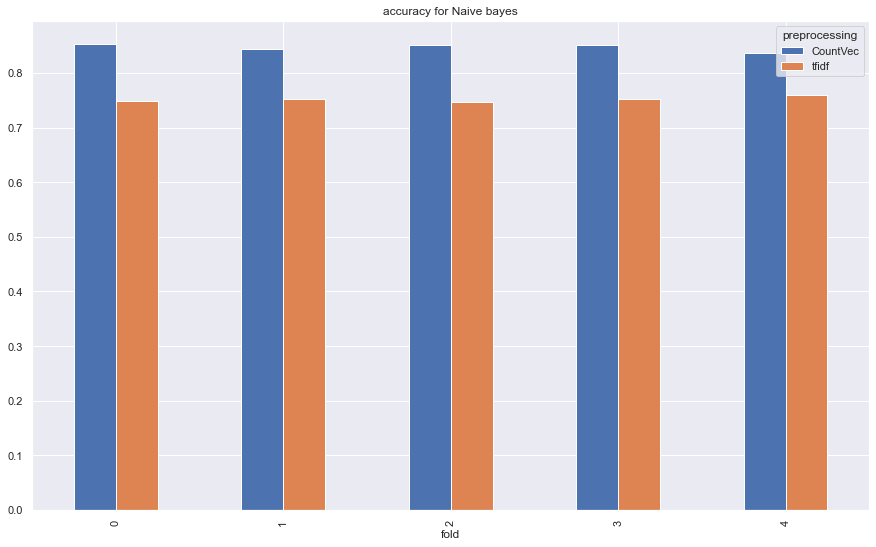

In [176]:
plot_results(results_data, 'accuracy', 'Naive bayes')